# DAY 1

# Lab - Data Transformation

In [35]:
import pandas as pd
import numpy as np
import statistics as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler, minmax_scale
%matplotlib inline

from scipy.stats import iqr
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [2]:
df = pd.read_csv('Data_Marketing_Customer_Analysis_Round3.csv')

In [3]:
numeric = df.select_dtypes(include=[np.number])
categorical = df.select_dtypes(include=[object])


* ### Check if there are highly correlated features and drop them if there are any.

In [4]:
#no correlation >= 0.9

* ### One Hot/Label Encoding of the categorical variables in the categoricals data frame that you created in Activity 3. 

In [5]:
categorical.drop(columns=['effective_to_date', 'month'], inplace=True)
categorical['response'] = pd.get_dummies(categorical['response'], drop_first=True)
categorical = pd.get_dummies(categorical, columns = ['region', 'location_code', 'policy_type', 'policy',
                                                     'sales_channel', 'vehicle_class', 'gender',
                                                     'employment_status', 'marital_status',
                                                     'renew_offer_type'])

categorical['coverage'].replace({'basic': 1, 
                                 'extended': 2, 
                                 'premium': 3}, inplace=True)

categorical['education'].replace({'high school or below': 0, 
                                  'college': 1, 
                                  'bachelor': 1,
                                  'master': 2,
                                  'doctor': 3}, inplace=True)

categorical['vehicle_size'].replace({'small': 0,
                                     'medsize': 1,
                                     'large': 2}, inplace=True)

In [6]:
categorical

,response,coverage,education,vehicle_size,region_central,region_east,region_north west,region_west region,location_code_rural,location_code_suburban,...,employment_status_medical leave,employment_status_retired,employment_status_unemployed,marital_status_divorced,marital_status_married,marital_status_single,renew_offer_type_offer1,renew_offer_type_offer2,renew_offer_type_offer3,renew_offer_type_offer4
0,0,1,1,1,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
1,0,1,1,1,0,0,0,1,0,1,...,0,0,1,0,0,1,0,0,0,1
2,0,1,1,1,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
3,1,2,1,1,0,0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0
4,0,3,1,1,0,0,1,0,0,1,...,1,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,0,3,1,1,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
10685,0,1,1,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
10686,0,2,1,1,1,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
10687,0,3,1,1,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0


## Optional

* ### Begin by visually examining distributions (histograms) of the numerical features. Select a variable, call it varA, which takes on a wide range of numerical values, and another, varB, which has noticeably large skew (slanted with respect to the mean). For example, you might select customer_lifetime_value as a candidate varB which has skew.

In [7]:
#varB skew (customer lifetime value)
#numeric['customer_lifetime_value'].hist()

In [8]:
varA = numeric['income']
varB = numeric['customer_lifetime_value']

* ### (VarA) Use minmax transform to bring varA's values into the range [0,1].

In [9]:
minmax_varA = minmax_scale(varA)

* ### (varA) Check that varA has been rescaled using a distplot or a histagram.

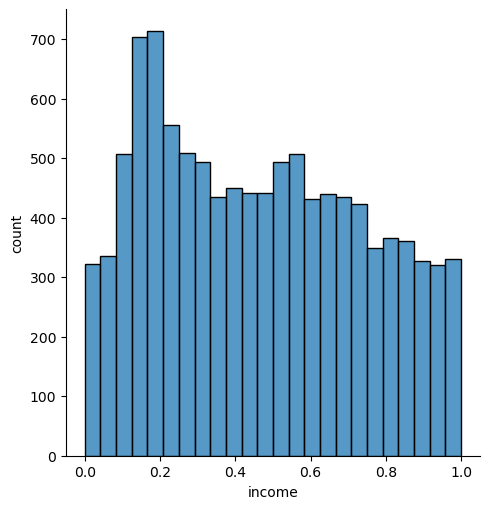

In [10]:
sns.displot(minmax_varA).set_axis_labels('income', 'count')

* ### (varB) Use StandardScalar or PowerTransform to reduce the skew and standardize varB's distribution.

In [11]:
pt = PowerTransformer()

varB = varB.to_numpy()
varB = np.reshape(varB, (-1, 1))
pt.fit(varB)
varB = pt.transform(varB)

varB

array([[-0.33614341],
       [-1.86720472],
       [ 1.2922699 ],
       ...,
       [ 1.79973101],
       [ 1.0217405 ],
       [ 0.24359374]])

* ### (varB) Check that the result has zero mean, unit variance, and reduced skew using mean(), std(), and a plot of the PDF.

In [12]:
round(varB.mean(), 1)

0.0

In [13]:
np.std(varB)

1.0000000000000002

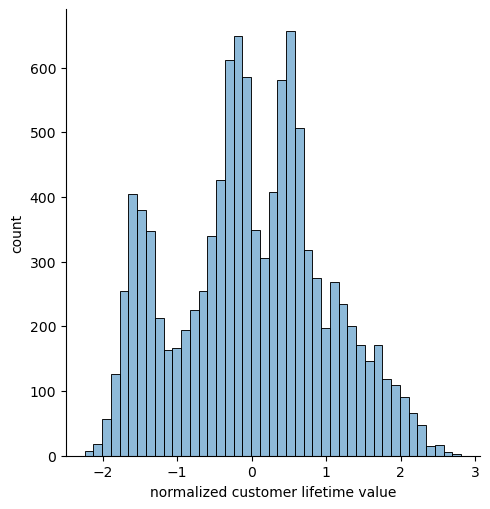

In [14]:
sns.displot(varB, legend=False).set_axis_labels('normalized customer lifetime value', 'count')

# DAY 2

# Linear Regression

* ### X-y split (y is the target variable, which is the total claim amount)

In [15]:
#remove outliers func
def remove_outliers(df):
    for c in df.columns:
            pct_75 = np.percentile(df[c], 75)
            pct_25 = np.percentile(df[c], 25)
            upper_bound = pct_75 + 1.5*iqr(df[c])
            lower_bound = pct_25 - 1.5*iqr(df[c])
            condition = (df[c] < upper_bound) & (df[c] > lower_bound)
            df[c] = df[c][condition]
    return df

In [16]:
df = pd.concat([categorical, remove_outliers(numeric)], axis =1)

In [17]:
df.isnull().any()

response                           False
coverage                           False
education                          False
vehicle_size                       False
region_central                     False
region_east                        False
region_north west                  False
region_west region                 False
location_code_rural                False
location_code_suburban             False
location_code_urban                False
policy_type_corporate auto         False
policy_type_personal auto          False
policy_type_special auto           False
policy_corporate l1                False
policy_corporate l2                False
policy_corporate l3                False
policy_personal l1                 False
policy_personal l2                 False
policy_personal l3                 False
policy_special l1                  False
policy_special l2                  False
policy_special l3                  False
sales_channel_agent                False
sales_channel_br

In [18]:
df.fillna({'customer_lifetime_value': 0, 
          'monthly_premium_auto': 0,
          'number_of_open_complaints': 0,
          'number_of_policies': 0,
          'total_claim_amount': 0}, inplace=True)

In [19]:
#check for nan
df.isnull().values.any()

False

In [20]:
X = df.drop('total_claim_amount', axis=1)
y = df[['total_claim_amount']]

In [21]:
na_idcs = X[X.isna().any(axis=1)].index
print(na_idcs)
# X = pd.DataFrame(X).drop(na_idcs)
# y = pd.DataFrame(y).drop(na_idcs)


Int64Index([], dtype='int64')


* ### Train-test split.

In [22]:
RAND_STATE = 100
TT_RATIO = 0.3

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

* ### Standardize the data (after the data split).

In [24]:
df

,response,coverage,education,vehicle_size,region_central,region_east,region_north west,region_west region,location_code_rural,location_code_suburban,...,renew_offer_type_offer3,renew_offer_type_offer4,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
0,0,1,1,1,1,0,0,0,0,1,...,1,0,4809.0,48029,61.0,7,52,0.0,0.0,292.0
1,0,1,1,1,0,0,0,1,0,1,...,0,1,2228.0,92260,64.0,3,26,0.0,1.0,744.0
2,0,1,1,1,0,1,0,0,0,1,...,1,0,14947.0,22139,100.0,34,31,0.0,2.0,480.0
3,1,2,1,1,0,0,1,0,0,1,...,0,0,0.0,49078,97.0,10,3,0.0,2.0,484.0
4,0,3,1,1,0,0,1,0,0,1,...,0,0,9025.0,23675,117.0,33,31,0.0,7.0,707.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,0,3,1,1,1,0,0,0,0,1,...,1,0,15563.0,61541,0.0,12,40,0.0,7.0,0.0
10685,0,1,1,1,0,0,1,0,0,0,...,0,0,5259.0,61146,65.0,7,68,0.0,6.0,273.0
10686,0,2,1,1,1,0,0,0,1,0,...,0,0,0.0,39837,0.0,11,63,0.0,2.0,381.0
10687,0,3,1,1,0,0,0,1,0,0,...,0,0,11971.0,64195,158.0,0,27,0.0,6.0,618.0


In [25]:
columns_X = list(df.drop('total_claim_amount', axis=1).columns)

# numeric_columnsX = list(numeric.drop('total_claim_amount', axis=1).columns)
# categorical_columnsX = list(categorical.columns)

In [26]:
pt = PowerTransformer()
ct = ColumnTransformer([("pt", pt, columns_X)],
                        #("cat", pass, categorical_columnsX)],
                        remainder='drop',verbose_feature_names_out=True,verbose=True).fit(X_train)


X_train_ct = pd.DataFrame(ct.transform(X_train),columns=ct.get_feature_names_out())
X_test_ct = pd.DataFrame(ct.transform(X_test),columns=ct.get_feature_names_out())


[ColumnTransformer] ............ (1 of 1) Processing pt, total=   0.2s


/Users/vladislavlis/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [27]:
X_train = pd.DataFrame(X_train_ct)
X_train

,pt__response,pt__coverage,pt__education,pt__vehicle_size,pt__region_central,pt__region_east,pt__region_north west,pt__region_west region,pt__location_code_rural,pt__location_code_suburban,...,pt__renew_offer_type_offer2,pt__renew_offer_type_offer3,pt__renew_offer_type_offer4,pt__customer_lifetime_value,pt__income,pt__monthly_premium_auto,pt__months_since_last_claim,pt__months_since_policy_inception,pt__number_of_open_complaints,pt__number_of_policies
0,-0.390734,-0.785510,-1.392453,0.141274,1.572748,-0.310005,-0.626926,-0.721403,-0.491758,-1.309129,...,1.481914,-0.436844,-0.354430,0.229367,1.294576,-0.357674,0.496117,-0.456447,0.0,0.537290
1,2.559287,-0.785510,-1.392453,0.141274,-0.635830,-0.310005,-0.626926,1.386187,-0.491758,0.763867,...,-0.674803,-0.436844,-0.354430,-0.765527,-1.255218,-0.669948,0.238235,1.466368,0.0,-0.799022
2,-0.390734,-0.785510,1.463733,2.059231,-0.635830,-0.310005,1.595084,-0.721403,2.033521,-1.309129,...,-0.674803,-0.436844,-0.354430,0.081101,1.603538,-0.392596,1.518133,-0.057832,0.0,0.537290
3,-0.390734,-0.785510,0.322694,-1.698583,-0.635830,-0.310005,-0.626926,1.386187,-0.491758,0.763867,...,1.481914,-0.436844,-0.354430,-2.307217,-0.778772,-0.566375,0.964263,-1.298909,0.0,0.008713
4,-0.390734,1.160204,0.322694,2.059231,-0.635830,3.225754,-0.626926,-0.721403,-0.491758,0.763867,...,-0.674803,-0.436844,-0.354430,0.319079,-0.149345,-0.111733,0.658427,-0.307800,0.0,1.850109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7477,-0.390734,-0.785510,0.322694,0.141274,-0.635830,3.225754,-0.626926,-0.721403,-0.491758,-1.309129,...,1.481914,-0.436844,-0.354430,-0.737606,-0.047787,-0.772976,-1.457712,0.181359,0.0,-0.799022
7478,-0.390734,1.588680,-1.392453,0.141274,1.572748,-0.310005,-0.626926,-0.721403,2.033521,-1.309129,...,-0.674803,2.289148,-0.354430,0.950756,0.966757,1.114893,-0.242617,-0.057832,0.0,0.537290
7479,-0.390734,-0.785510,-1.392453,0.141274,-0.635830,-0.310005,1.595084,-0.721403,-0.491758,0.763867,...,-0.674803,-0.436844,2.821432,0.465505,-1.648966,-0.807193,1.179911,-1.250888,0.0,0.008713
7480,-0.390734,-0.785510,-1.392453,2.059231,-0.635830,-0.310005,1.595084,-0.721403,2.033521,-1.309129,...,1.481914,-0.436844,-0.354430,0.834831,1.381259,0.968125,-1.670147,0.147773,0.0,0.537290


* ### Apply linear regression.

In [28]:
X_train = sm.add_constant(X_train.to_numpy()) # adding a constant
model = sm.OLS(y_train, X_train).fit()

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     159.9
Date:                Wed, 01 Feb 2023   Prob (F-statistic):               0.00
Time:                        15:26:27   Log-Likelihood:                -48712.
No. Observations:                7482   AIC:                         9.751e+04
Df Residuals:                    7440   BIC:                         9.780e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        371.0699      1.891    196.224      0.0

In [29]:
#predictions_train = model.predict(X_train_const_ct)
X_test = sm.add_constant(X_test) # adding a constant
#predictions_test = model.predict(X_test_const_ct)

model.predict(X_test)

9700    4.820998e+14
4662    5.088409e+14
1401    2.323961e+14
6313    5.069820e+14
8906    4.390950e+14
            ...     
2913    4.573188e+14
8340    4.697769e+14
5910    4.709444e+14
3016    5.067619e+14
9490    4.934131e+14
Length: 3207, dtype: float64

* ### Model Interpretation.

In [30]:
model=LinearRegression()    # model
model.fit(X_train, y_train)   # model train

LinearRegression()

In [31]:
model.coef_

array([[ 4.43217113e+08, -6.56333469e+00,  5.55288859e+00,
        -1.16431992e+00, -4.38631669e+00,  3.03892507e+13,
         1.89823552e+13,  3.02055486e+13,  3.18453852e+13,
         7.50034336e+14,  9.13675824e+14,  7.17643938e+14,
         1.39678737e+15, -3.44302839e+14, -1.09652410e+15,
        -7.83157541e+14, -1.00517397e+15, -1.26328839e+15,
         5.09411278e+13,  6.25067567e+13,  7.12464676e+13,
         4.38307018e+14,  6.19959857e+14,  6.25062987e+14,
         7.83263680e+14,  7.28110682e+14,  6.39272719e+14,
         5.78939263e+14,  6.97672110e+14,  1.89099651e+14,
         1.93030354e+14,  3.06027201e+14,  5.59408932e+14,
         5.60241513e+14,  1.49716560e+14,  1.49716560e+14,
         1.99719044e+14,  4.62193089e+14,  1.97213336e+14,
         1.62862766e+14,  4.16360812e+14,  6.84059549e+13,
         9.46415227e+13,  8.55265063e+13,  1.66797215e+15,
         1.56947228e+15,  1.24171595e+15,  1.06582332e+15,
         9.39257812e+00, -9.52148438e-01,  4.96328125e+0

In [32]:
model.intercept_

array([-4.43216742e+08])

* ### Model evaluation

In [39]:
y_pred = pd.DataFrame(model.predict(X_test),columns = ['claim_amount'] )      # model prediction
y_pred_train =  pd.DataFrame(model.predict(X_train),columns = ['claim_amount'])


/Users/vladislavlis/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [42]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))
print(mse(y_train,y_pred_train))

1.7616394158917568e+31
4179575796998692.0
26463.97121522679


In [43]:
R2=r2_score(y_test,y_pred)
R2

-3.5691691647473095e+26